In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [4]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [5]:
!nvidia-smi

Wed Jan 27 16:50:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W /  75W |    209MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
%cd '/gdrive/My Drive/Tavsiye_Sistemi/'

/gdrive/My Drive/Tavsiye_Sistemi


In [7]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [8]:
import numpy as numpy
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib


# Set Up Paths for Images

In [10]:
data_dir = pathlib.Path('/gdrive/My Drive/Tavsiye_Sistemi/images')
len(list(data_dir.glob('*/*.jpg')))

4001

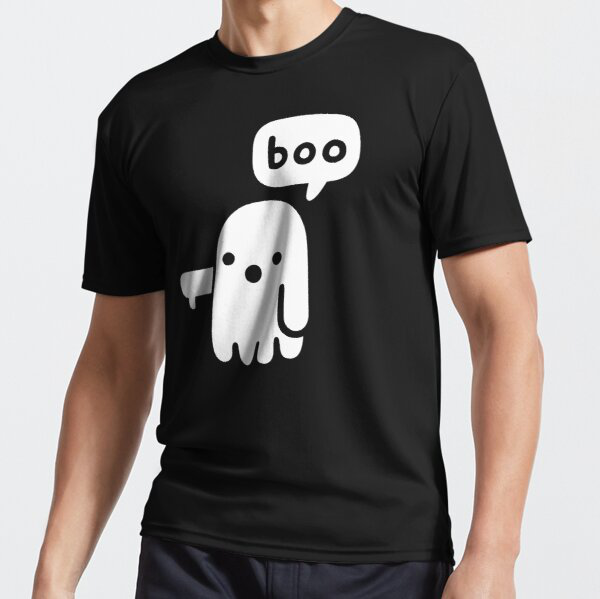

In [11]:
manActive = list(data_dir.glob('Man Active/*'))
PIL.Image.open(str(manActive[1]))

# Training - Transfer Learning Model

In [12]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [13]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False, weights='imagenet')
base_model.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [14]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
!ls


chromedriver		  README.md		Tshirt5.jpg
chromedriver.exe	  Recommendation.ipynb	Tshirt6.jpg
chromedriver_linux64.zip  result.p		Tshirt7.jpg
file_mapping		  streamlit_app.py	Tshirt8.jpg
images			  style_stack.py	Tshirt9.jpg
info			  Tshirt10.jpg		Untitled0.ipynb
lib			  Tshirt1.jpg		utils.py
logs			  Tshirt2.jpg		vgg16_tshirt_classifier_1129.h5
output			  Tshirt3.jpg		vgg_classifier.ipynb
__pycache__		  Tshirt4.jpg


In [16]:
batch_size = 64

preprocess_input = tf.keras.applications.vgg16.preprocess_input

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='training',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='validation',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3201 images belonging to 10 classes.
Found 800 images belonging to 10 classes.


In [17]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 7, 7, 512)
(64, 512)


In [18]:
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc1')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc2')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=base_model.input, outputs=x)

In [19]:
base_learning_rate = 0.0001
model_2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

model_2.summary()        

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
weights_file = '/gdrive/My Drive/Tavsiye_Sistemi/vgg16_tshirt_classifier_1129.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

'''
import os
import datetime
from tensorflow.keras.callbacks import TensorBoard
log_dir = os.path.join(
    "logs",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
'''
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/gdrive/My Drive/Tavsiye_Sistemi/logs', histogram_freq=0, write_graph=True, write_images=False)


In [21]:
history = model_2.fit(
    train_generator,
    steps_per_epoch=3110//batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=772//batch_size,
    verbose=1,
    workers=4,
    callbacks=[checkpoint,early,tensorboard]
)

Epoch 1/15
48/48 [==============================] - 341s 7s/step - loss: 7.9757 - accuracy: 0.6750 - val_loss: 0.1916 - val_accuracy: 0.9766

Epoch 00001: val_accuracy improved from -inf to 0.97656, saving model to /gdrive/My Drive/Tavsiye_Sistemi/vgg16_tshirt_classifier_1129.h5
Epoch 2/15
48/48 [==============================] - 64s 1s/step - loss: 0.1128 - accuracy: 0.9840 - val_loss: 0.0992 - val_accuracy: 0.9844

Epoch 00002: val_accuracy improved from 0.97656 to 0.98438, saving model to /gdrive/My Drive/Tavsiye_Sistemi/vgg16_tshirt_classifier_1129.h5
Epoch 3/15
48/48 [==============================] - 63s 1s/step - loss: 0.2133 - accuracy: 0.9821 - val_loss: 0.4435 - val_accuracy: 0.9674

Epoch 00003: val_accuracy did not improve from 0.98438
Epoch 4/15
48/48 [==============================] - 60s 1s/step - loss: 0.1694 - accuracy: 0.9841 - val_loss: 0.0573 - val_accuracy: 0.9961

Epoch 00004: val_accuracy improved from 0.98438 to 0.99609, saving model to /gdrive/My Drive/Tavsiye_

# Plot Accuracy and Loss of Model

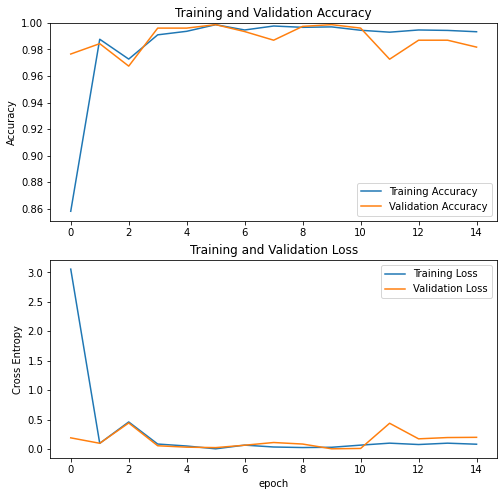

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Visualize Feature Maps

In [23]:
from keras.preprocessing import image
preprocess_input = tf.keras.applications.vgg16.preprocess_input
from keras.models import Model
import numpy as np
from matplotlib import pyplot

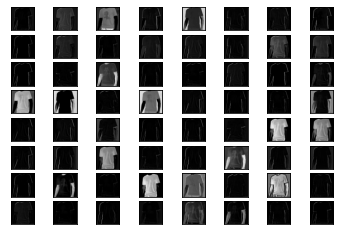

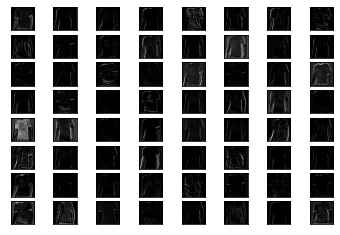

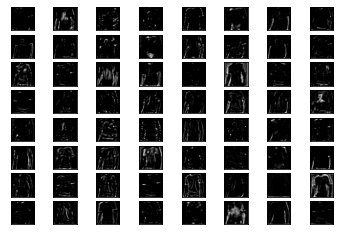

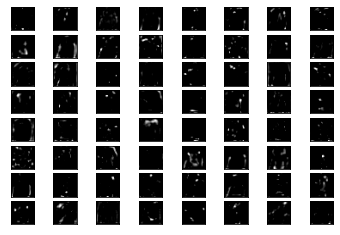

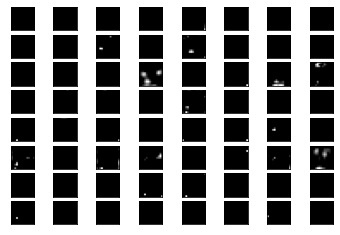

In [24]:
ixs = [2, 5, 9, 13, 17]
outputs = [model_2.layers[i].output for i in ixs]
model = Model(inputs=model_2.inputs, outputs=outputs)
img = image.load_img('/gdrive/My Drive/Tavsiye_Sistemi/images/Man Active/ssrco,active_tshirt,mens,101010_01c5ca27c6,front,square_product,600x600 - 2021-01-05T134341.064.jpg', target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
feature_maps = model.predict(img)
square = 8
for fmap in feature_maps:
	ix = 1
	for _ in range(square):
		for _ in range(square):
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	pyplot.show()